📊 VIF Scores:
               Feature        VIF
0               const  16.238983
1  Waste_Generated_kg   1.009112
2    CO2_Emissions_kg   1.001890
3  Renewable_Energy_%   1.007144
4              Cost_$   1.001102


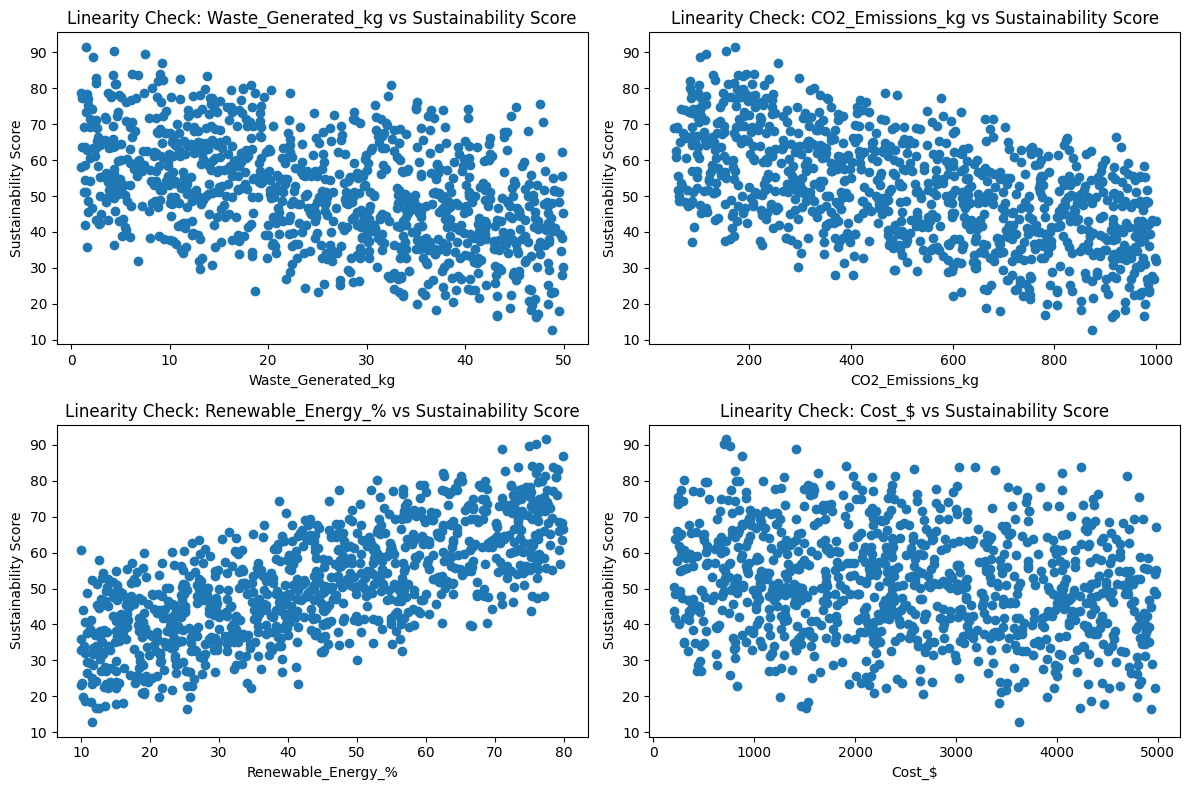


🔁 Model after Power Transformation (Yeo-Johnson):
                              OLS Regression Results                             
Dep. Variable:     Sustainability_Score   R-squared:                       0.994
Model:                              OLS   Adj. R-squared:                  0.994
Method:                   Least Squares   F-statistic:                 4.260e+04
Date:                  Sat, 03 May 2025   Prob (F-statistic):               0.00
Time:                          20:48:41   Log-Likelihood:                -1536.4
No. Observations:                  1000   AIC:                             3083.
Df Residuals:                       995   BIC:                             3107.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

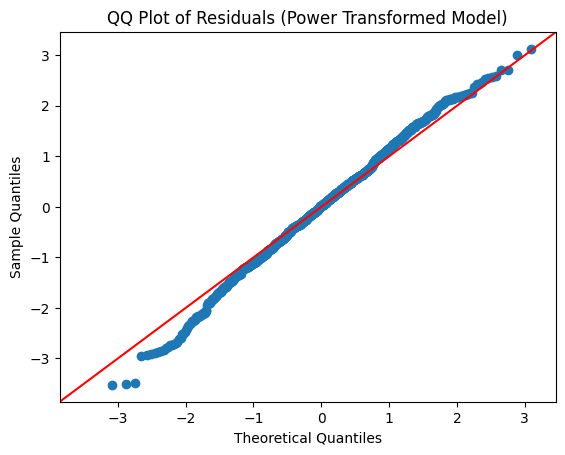


Shapiro-Wilk Test for Normality (Power Transformed Model): Stat=0.9970, p-value=0.0529

📈 Model Performance:
R²: 0.9942
MAE: 0.8943
RMSE: 1.1246


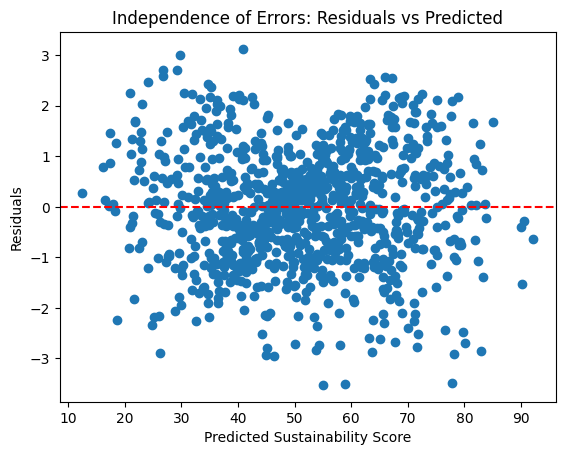

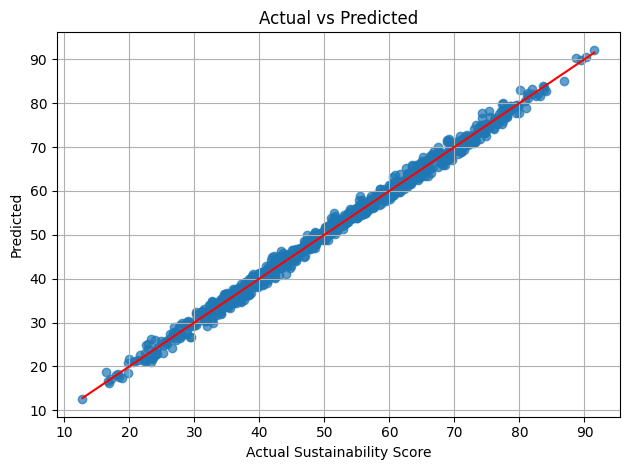

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Load data
df = pd.read_csv("green_supply_chain.csv")

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Define independent variables and target
features = ['Waste_Generated_kg', 'CO2_Emissions_kg', 'Renewable_Energy_%', 'Cost_$']
target = 'Sustainability_Score'
X = df[features]
y = df[target]

# ----- MULTICOLLINEARITY CHECK (VIF) -----
X_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]
print("📊 VIF Scores:\n", vif_data)

# ----- LINEARITY CHECK (Scatter Plots) -----
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.scatter(df[feature], y)
    plt.xlabel(feature)
    plt.ylabel('Sustainability Score')
    plt.title(f"Linearity Check: {feature} vs Sustainability Score")
plt.tight_layout()
plt.show()

# ----- POWER TRANSFORMATION (Yeo-Johnson) -----
# Apply PowerTransformer (Yeo-Johnson) to the features
pt = PowerTransformer(method='yeo-johnson')
df_transformed_pt = pt.fit_transform(df[features])
X_pt = pd.DataFrame(df_transformed_pt, columns=features)
X_pt_const = sm.add_constant(X_pt)

# ----- MODEL FITTING -----
pt_model = sm.OLS(y, X_pt_const).fit()
print("\n🔁 Model after Power Transformation (Yeo-Johnson):\n", pt_model.summary())

# ----- HOMOSCEDASTICITY CHECK (Breusch-Pagan) -----
bp_test_pt = het_breuschpagan(pt_model.resid, pt_model.model.exog)
labels = ['LM Stat', 'LM p-value', 'F-Stat', 'F p-value']
print("\n🧪 Homoscedasticity Test (Breusch-Pagan):")
for name, value in zip(labels, bp_test_pt):
    print(f"{name}: {value:.4f}")

# ----- NORMALITY OF RESIDUALS CHECK (QQ Plot and Shapiro-Wilk Test) -----
# QQ Plot
sm.qqplot(pt_model.resid, line='45')
plt.title("QQ Plot of Residuals (Power Transformed Model)")
plt.show()

# Shapiro-Wilk Test
stat_pt, p_value_pt = stats.shapiro(pt_model.resid)
print(f"\nShapiro-Wilk Test for Normality (Power Transformed Model): Stat={stat_pt:.4f}, p-value={p_value_pt:.4f}")

# ----- MODEL EVALUATION -----
y_pred = pt_model.predict(X_pt_const)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"\n📈 Model Performance:\nR²: {r2:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}")

# ----- INDEPENDENCE OF ERRORS CHECK (Residuals Plot) -----
plt.scatter(y_pred, pt_model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sustainability Score')
plt.ylabel('Residuals')
plt.title('Independence of Errors: Residuals vs Predicted')
plt.show()

# Plot actual vs predicted
plt.scatter(y, y_pred, alpha=0.7)
plt.xlabel("Actual Sustainability Score")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()
